# Ebay Competitive Auctions Classifier

This notebook covers the steps taken to build a decision tree to help classify whether an ebay auction would be competitive or not.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
import copy

In [2]:
!pip install graphviz

/usr/bin/sh: pip: command not found


In [3]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

### Import the Data

In [4]:
data = pd.read_csv('ebayAuctions.csv')
data.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
Category        1972 non-null object
Currency        1972 non-null object
sellerRating    1972 non-null int64
Duration        1972 non-null int64
endDay          1972 non-null object
ClosePrice      1972 non-null float64
OpenPrice       1972 non-null float64
Competitive?    1972 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 123.3+ KB


### Check for missing Values

In [6]:
data.isnull().sum()

Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive?    0
dtype: int64

There are no missing values

### Check for Correlations

In [7]:
correlation = data.corr() # correlation matrix
correlation

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
sellerRating,1.000000,-0.149734,0.000158,-0.041113,-0.033956
Duration,-0.149734,1.000000,-0.090714,-0.085289,-0.026478
ClosePrice,0.000158,-0.090714,1.000000,0.476931,0.178458
OpenPrice,-0.041113,-0.085289,0.476931,1.000000,-0.096646
Competitive?,-0.033956,-0.026478,0.178458,-0.096646,1.000000


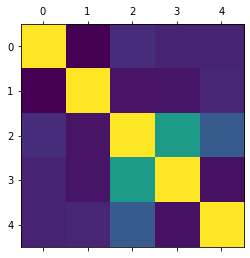

In [8]:
plt.matshow(data.corr()) # correlation matrix with different colour
plt.show()

Only Close Price and Open Price seem to be slightly correlated.

## Check for Outliers

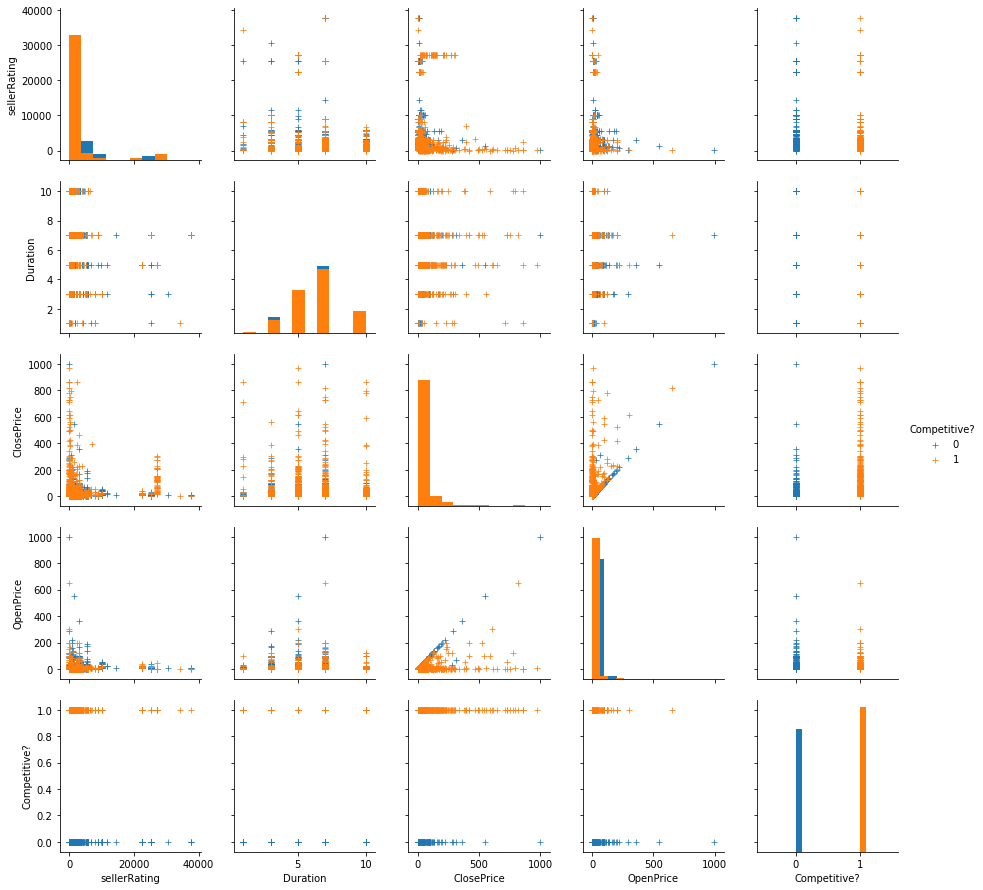

In [9]:
# scatterplots for all variables before data preprocessing
pplt = sns.pairplot(data, hue="Competitive?", markers="+", diag_kind="hist")
plt.show()

There seem to be no outliers

### Create Dummy Variables for all Categorical predictors

In [10]:
data.info()
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
Category        1972 non-null object
Currency        1972 non-null object
sellerRating    1972 non-null int64
Duration        1972 non-null int64
endDay          1972 non-null object
ClosePrice      1972 non-null float64
OpenPrice       1972 non-null float64
Competitive?    1972 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 123.3+ KB
(1972, 8)


In [11]:
print(data.shape)
data.info()

# create dummy variables for category, currency, endDay, and duration
dummies_category = pd.get_dummies(data['Category'])
print(dummies_category)
dummies_currency = pd.get_dummies(data['Currency'])
dummies_endDay = pd.get_dummies(data['endDay'])
dummies_duration = pd.get_dummies(data['Duration'])

# copy data in file data1
data1 = copy.deepcopy(data)
print(data.shape)
columns2=['Category','Currency','endDay','Duration']
data1 = data1.drop(columns2, axis=1)
data1 = pd.concat([data1,dummies_category],axis=1)
data1 = pd.concat([data1,dummies_currency],axis=1)
data1 = pd.concat([data1,dummies_endDay],axis=1)
data1 = pd.concat([data1,dummies_duration],axis=1)
data1.info()
print(data1.shape)

(1972, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
Category        1972 non-null object
Currency        1972 non-null object
sellerRating    1972 non-null int64
Duration        1972 non-null int64
endDay          1972 non-null object
ClosePrice      1972 non-null float64
OpenPrice       1972 non-null float64
Competitive?    1972 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 123.3+ KB
      Antique/Art/Craft  Automotive  Books  Business/Industrial  \
0                     0           0      0                    0   
1                     0           0      0                    0   
2                     0           0      0                    0   
3                     0           0      0                    0   
4                     0           0      0                    0   
5                     0           0      0                    0   
6                     0           0      0              

### Create Train/Test Split

In [12]:
# separate X and Y variables. Using all X predictors
dfX1 = data1.loc[:, data1.columns != 'Competitive?']
dfY1 = data1["Competitive?"]

In [13]:
# split with 60% training data and 40% of test data
X_train, X_test, Y_train, Y_test = train_test_split(dfX1, dfY1, train_size=0.6, test_size=0.4, random_state=0)

In [14]:
Y_test.value_counts()

1    419
0    370
Name: Competitive?, dtype: int64

In [15]:
data1['EUR'].value_counts()

0    1439
1     533
Name: EUR, dtype: int64

## Decision Tree Model

## Tree 1 - Using all the variables

As an intial run all the predictors are used. The model will be improved in the next iteration.

### Train Model

In [16]:
# min_samples_leaf set to 50
tree = DecisionTreeClassifier(min_samples_leaf = 50)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
Y_predicted = tree.predict(X_test)
Y_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,

### Accuracy Score

In [18]:
# return tree score of the model
tree.score(X_test, Y_test)

0.8288973384030418

### Confusion Matrix

In [19]:
# create confusion matrix
confusion_matrix = confusion_matrix(Y_test, Y_predicted)
confusion_matrix

array([[325,  45],
       [ 90, 329]])

In [20]:
print(tree)
dot_data = export_graphviz(tree, out_file = None, feature_names=X_train.columns, node_ids=True, filled=True)
graph = graphviz.Source(dot_data)
graph.render()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


'Source.gv.pdf'

In [21]:
from sklearn.tree import export_text

print(export_text(tree))

|--- feature_2 <= 3.69
|   |--- feature_1 <= 3.64
|   |   |--- feature_2 <= 1.04
|   |   |   |--- class: 1
|   |   |--- feature_2 >  1.04
|   |   |   |--- feature_2 <= 2.45
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  2.45
|   |   |   |   |--- class: 0
|   |--- feature_1 >  3.64
|   |   |--- feature_35 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_35 >  0.50
|   |   |   |--- class: 1
|--- feature_2 >  3.69
|   |--- feature_0 <= 591.50
|   |   |--- feature_1 <= 15.11
|   |   |   |--- class: 0
|   |   |--- feature_1 >  15.11
|   |   |   |--- feature_2 <= 12.18
|   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  12.18
|   |   |   |   |--- class: 1
|   |--- feature_0 >  591.50
|   |   |--- feature_1 <= 10.00
|   |   |   |--- feature_2 <= 4.99
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  4.99
|   |   |   |   |--- feature_1 <= 7.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  7.99
|   |   |   |   |   |--- class: 0
|   |   

In [22]:
export_graphviz(tree, out_file = "DecisionTree1.dot", feature_names=X_train.columns)

In [23]:
feature = tree.tree_.feature
X_test

,sellerRating,ClosePrice,OpenPrice,Antique/Art/Craft,Automotive,Books,Business/Industrial,Clothing/Accessories,Coins/Stamps,Collectibles,...,Sat,Sun,Thu,Tue,Wed,1,3,5,7,10
18,3115,0.01,0.01,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
294,1148,3.93,1.77,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1174,1581,87.31,1.23,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1702,1809,26.07,19.99,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
512,2378,860.00,0.01,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
711,1634,5.53,4.90,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
634,71,18.58,1.23,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
276,3380,2.23,2.23,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1003,686,6.50,6.50,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1529,25433,14.95,14.95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# Code for Printing rules for Tree 1
# ***************************************************************************************
# *    Title: sklearn.tree.export_graphviz¶
# *    Author: <author(s) names>
# *    Date: <date>
# *    Code version: <code version>
# *    Availability: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
# *
# ***************************************************************************************

# The following code generate extract decision rules from the tree. 
node_indicator = tree.decision_path(X_train)
n_nodes = tree.tree_.node_count
feature = tree.tree_.feature
threshold = tree.tree_.threshold
leave_id = tree.apply(X_train)

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right
feature = tree.tree_.feature
threshold = tree.tree_.threshold


node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
  
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("**********************************************************************************\n",
      "The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: IF %s <= %s, THEN go to node %s ELSE to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 data1.columns[feature[i]],
                 threshold[i],
                 children_left[i],
                 children_right[i],
                 ))
print()

**********************************************************************************
 The binary tree structure has 29 nodes and has the following tree structure:
node=0 test node: IF OpenPrice <= 3.6850000619888306, THEN go to node 1 ELSE to node 10.
	node=1 test node: IF ClosePrice <= 3.6449999809265137, THEN go to node 2 ELSE to node 7.
		node=2 test node: IF OpenPrice <= 1.0350000262260437, THEN go to node 3 ELSE to node 4.
			node=3 leaf node.
			node=4 test node: IF OpenPrice <= 2.4450000524520874, THEN go to node 5 ELSE to node 6.
				node=5 leaf node.
				node=6 leaf node.
		node=7 test node: IF 7 <= 0.5, THEN go to node 8 ELSE to node 9.
			node=8 leaf node.
			node=9 leaf node.
	node=10 test node: IF sellerRating <= 591.5, THEN go to node 11 ELSE to node 16.
		node=11 test node: IF ClosePrice <= 15.105000019073486, THEN go to node 12 ELSE to node 13.
			node=12 leaf node.
			node=13 test node: IF OpenPrice <= 12.175000190734863, THEN go to node 14 ELSE to node 15.
				node=14 l

### Interpretation of Decision Tree 1

The blue color of the nodes indicates that the majority of the prediction is “Competitive” (y =1). The orange color of the nodes indicates that the prediction is “non-competitive” (y = 0). Denser color of the nodes indicates higher purity of the nodes. 

Looking at the results from the Decision Tree it seems to treat OpenPrice, SellerRating, ClosePrice and whether the auction lasted 10 days or not as important predictors for partitioning the competitive auctions from non-competitive auctions. Among them, Open Price and closePrice are particularly important, since splits on these variables are recurrent at different levels of the tree

### Is this a good Model? - Practicality of Tree in Interpreting whether an Auction is Competitive or not

This tree model does not perform well in predicting if an auction is competitive or not since a lot of nodes are not pure (many nodes have non-zero gini index), indicating competitive and non-competitive auction points are mixing together. Considering that ClosePrice is not available until the end of auction and the purity of nodes, we concluded that this model was not practical for predicting the outcome of a new auction

## Tree 2

## Dropping the 'Close Price' Predictor

The variable “ClosePrice” is removed because it is not useful for predicting the outcome of a new prediction – it is impossible to know the close price before the auction ends. Note that the variable “duration” is kept in the model because the duration of an auction is set before the auction begins, at least according to the descriptions in the guidelines for this assignment.

## Reducing Number of Categories

To improve the tree and make the tree easier to interpret, let's reduce the number of categorical variables by binning them

The variable “endDay” was removed because it is redundant to the “Duration” variable.

In [25]:
# dimensonality Reduction: Regroup 18 Category Levels into 9 Category Levels. 
data["Category_Trans"] = data["Category"].map({"Electronics": "Electronics", "Computer": "Electronics", 
                                               "Coins/Stamps": "Arts", "Collectibles": "Arts", "Pottery/Glass": "Arts","Antique/Art/Craft": "Arts", 
                                               "Toys/Hobbies": "Hobbies","Photography": "Hobbies","Music/Movie/Game": "Hobbies", "Books": "Hobbies",
                                               "SportingGoods": "Hobbies", "Home/Garden": "Home/Garden", "Health/Beauty": "Health/Beauty",
                                              "EverythingElse": "EverythingElse", "Automotive": "Automotive", "Business/Industrial": "Business/Industrial",
                                               "Clothing/Accessories": "Clothing", "Jewelry": "Clothing"})


dummies_category = pd.get_dummies(data['Category_Trans'])
dummies_currency = pd.get_dummies(data['Currency'])
dummies_endDay = pd.get_dummies(data['endDay'])
dummies_duration = pd.get_dummies(data['Duration'])

data2 = pd.concat([data,dummies_category,dummies_currency, dummies_endDay], axis = 1)
data2 = data2.drop(['Category_Trans', 'Category', 'Currency', 'endDay', 'ClosePrice', 'Duration' ], axis=1)


data2.info()

dfX = data2.loc[:, data2.columns != 'Competitive?']
dfY = data2[['Competitive?']]

# separate X and Y variables. Using all X predictors
dfX1 = data1.loc[:, data1.columns != 'Competitive?']
dfY1 = data1["Competitive?"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 22 columns):
sellerRating           1972 non-null int64
OpenPrice              1972 non-null float64
Competitive?           1972 non-null int64
Arts                   1972 non-null uint8
Automotive             1972 non-null uint8
Business/Industrial    1972 non-null uint8
Clothing               1972 non-null uint8
Electronics            1972 non-null uint8
EverythingElse         1972 non-null uint8
Health/Beauty          1972 non-null uint8
Hobbies                1972 non-null uint8
Home/Garden            1972 non-null uint8
EUR                    1972 non-null uint8
GBP                    1972 non-null uint8
US                     1972 non-null uint8
Fri                    1972 non-null uint8
Mon                    1972 non-null uint8
Sat                    1972 non-null uint8
Sun                    1972 non-null uint8
Thu                    1972 non-null uint8
Tue                    1972 non

## Reduced Tree

In [27]:
# dummies_category = pd.get_dummies(data['Category_Trans'])
dummies_category = pd.get_dummies(data['Category'])
dummies_currency = pd.get_dummies(data['Currency'])
dummies_endDay = pd.get_dummies(data['endDay'])
# dummies_duration = pd.get_dummies(data['Duration'])

data2 = pd.concat([data,dummies_category,dummies_currency, dummies_endDay ], axis = 1)
data2 = data2.drop(['Category_Trans', 'Category', 'Currency', 'endDay', 'ClosePrice' ], axis=1)

dfX = data2.loc[:, data2.columns != 'Competitive?']
dfY = data2["Competitive?"]


print("These predictors are included in the model: \n")
dfX.info()
print("**********************************************************************************\n")

X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, train_size=0.6, test_size=0.4, random_state=0)
# separate X and Y variables. Using all X predictors

These predictors are included in the model: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 31 columns):
sellerRating            1972 non-null int64
Duration                1972 non-null int64
OpenPrice               1972 non-null float64
Antique/Art/Craft       1972 non-null uint8
Automotive              1972 non-null uint8
Books                   1972 non-null uint8
Business/Industrial     1972 non-null uint8
Clothing/Accessories    1972 non-null uint8
Coins/Stamps            1972 non-null uint8
Collectibles            1972 non-null uint8
Computer                1972 non-null uint8
Electronics             1972 non-null uint8
EverythingElse          1972 non-null uint8
Health/Beauty           1972 non-null uint8
Home/Garden             1972 non-null uint8
Jewelry                 1972 non-null uint8
Music/Movie/Game        1972 non-null uint8
Photography             1972 non-null uint8
Pottery/Glass           1972 non-null uint8
SportingG

### Train tree 2

In [28]:
# min_samples_leaf set to 50
tree2 = DecisionTreeClassifier(min_samples_leaf = 50)
tree2.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
Y_predicted = tree2.predict(X_test)
Y_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

## Accuracy Score

In [30]:
# return tree score of the model
tree2.score(X_test, Y_test)

0.7072243346007605

Accuracy score lowered since we are no longer including 'Close Price'. This was expected, and not a reason to worry

## Confusion Matrix

In [31]:
# create confusion matrix
confusion_matrix = confusion_matrix(Y_test, Y_predicted)
confusion_matrix

TypeError: 'numpy.ndarray' object is not callable

In [32]:
dot_data = export_graphviz(tree2, out_file = None, feature_names=X_train.columns, node_ids = True, class_names = True, filled = True)
graph = graphviz.Source(dot_data)
graph.render()

#files.download('Source.gv.pdf')
export_graphviz(tree2, out_file = "DecisionTree2.dot", feature_names=X_train.columns)

print("The test score is %s \n" % (r_square))

NameError: name 'r_square' is not defined

## Extract Rules from Tree

In [33]:
# ***************************************************************************************
# *    Title: sklearn.tree.export_graphviz¶
# *    Author: <author(s) names>
# *    Date: <date>
# *    Code version: <code version>
# *    Availability: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
# *
# ***************************************************************************************

# The following code generate extract decision rules from the tree. 
node_indicator = tree2.decision_path(X_train)
n_nodes = tree2.tree_.node_count
feature = tree2.tree_.feature
threshold = tree2.tree_.threshold
leave_id = tree2.apply(X_train)

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

n_nodes = tree2.tree_.node_count
children_left = tree2.tree_.children_left
children_right = tree2.tree_.children_right
feature = tree2.tree_.feature
threshold = tree2.tree_.threshold


node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
  
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("**********************************************************************************\n",
      "The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: IF %s <= %s, THEN go to node %s ELSE to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 data2.columns[feature[i]],
                 threshold[i],
                 children_left[i],
                 children_right[i],
                 ))
print()

**********************************************************************************
 The binary tree structure has 33 nodes and has the following tree structure:
node=0 test node: IF OpenPrice <= 3.6850000619888306, THEN go to node 1 ELSE to node 14.
	node=1 test node: IF OpenPrice <= 1.0350000262260437, THEN go to node 2 ELSE to node 5.
		node=2 test node: IF OpenPrice <= 0.9399999976158142, THEN go to node 3 ELSE to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: IF sellerRating <= 2403.5, THEN go to node 6 ELSE to node 13.
			node=6 test node: IF OpenPrice <= 1.8350000381469727, THEN go to node 7 ELSE to node 10.
				node=7 test node: IF sellerRating <= 630.5, THEN go to node 8 ELSE to node 9.
					node=8 leaf node.
					node=9 leaf node.
				node=10 test node: IF sellerRating <= 1289.5, THEN go to node 11 ELSE to node 12.
					node=11 leaf node.
					node=12 leaf node.
			node=13 leaf node.
	node=14 test node: IF sellerRating <= 591.5, THEN go to node 15 ELSE t

## Interpretation of Tree 2

Duration, OpenPrice, SellerRating, the currency “EUR”, the “Music/Movie/Game” category, and the “Automotive” category are important predictors for partitioning the Competitive auctions from on-competitive auctions. Among them, Open Price is particularly important, since splits on this variable is recurrent at different levels of the tree. More specifically, lower Open Prices are associated with predictions of competitive auctions, and higher Open Prices are associated with predictions of non-competitive auctions. This result is expected because consumers more interested in bidding if the good is cheaper.

## Recommendations

* Lower Open Price, and not selling the product in Euro will increase the likelihood of competitive auction. 
    * The critical threshold for Open Price is 1.775, as indicated by the initial split at node #0. If possible, it is strongly recommended that the seller set the Open Price to less than 1.775. 
    * The seller is also encouraged to avoid selling the product in Euro for reasons mentioned already in this section. 

Two more specific recommendations are made based on the decision paths with the purist child nodes and leaves. Since prescriptions that include more details are more susceptible to inaccuracy, only the result of two purist partitions are included in this recommendation.

* Set the duration of the auction to less than 6 days
    * According to the decision path that ends at leaf node #3 and leaf node #4 (node #0 -> node #1 -> node #2 node -> node #3 and node #4):  Given that the seller set the open price to less than 1.775,  if the seller also sets the duration of the auction to less than 6 days, then the seller will very likely have a competitive auction. 
	According to the decision path that ends at node #32 (node #0 -> node #8 -> node #14 -> node #18 -> node #32), if the open price is greater than 1.775 (node #0), and if the seller’s rating is greater than 570 (node #8), and if the open price is greater than 3.82 (node #14), and if the product of concern is under the category “Automotive” (node #18), then the seller will very likely have a non-competitive auction (node #32). 
    
* If the seller is selling Automotive and cannot afford to or is unwilling to set the auction price to lower than 1.775, then the seller should expect the auction to be non-competitive and forgo their auction practice if non-competitive auctions are not acceptable to them.

